In [5]:
from model import StressModel
import agentpy as ap
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
sl_data = pd.read_csv('../data/processed/sl_data_complete.csv')
fbk_data = pd.read_csv('../data/processed/fbk_data_complete.csv')

sl_model = pickle.load(open('../trained_models/sl_data_complete_model_trained.pickle', "rb"))
sl_bin_model = pickle.load(open('../trained_models/sl_data_complete_binary_model_trained.pickle', "rb"))
sl_scaler = pickle.load(open('../trained_models/sl_data_complete_scaler_trained.pickle', "rb"))
sl_bin_scaler = pickle.load(open('../trained_models/sl_data_complete_binary_scaler_trained.pickle', "rb"))
fbk_model = pickle.load(open('../trained_models/fbk_data_complete_model_trained.pickle', "rb"))
fbk_scaler = pickle.load(open('../trained_models/fbk_data_complete_scaler_trained.pickle', "rb"))
fbk_bin_model = pickle.load(open('../trained_models/fbk_data_complete_binary_model_trained.pickle', "rb"))
fbk_bin_scaler = pickle.load(open('../trained_models/fbk_data_complete_binary_scaler_trained.pickle', "rb"))
sl_test_users = pickle.load(open('../trained_models/sl_data_complete_test_users.pickle', "rb"))
fbk_test_users = pickle.load(open('../trained_models/fbk_data_complete_test_users.pickle', "rb"))

In [151]:
parameters = {
    'dataset_path': '../data/processed/sl_data_complete.csv',
    'test_users': '../trained_models/sl_data_complete_test_users',
    'seed': 24091993,
    'i': ap.IntRange(0, 9),
    'predictor_path': '../trained_models/sl_data_complete_model_trained',
    'steps': sl_data.reset_index()['date'].unique().shape[0]-1,
    'dataset_name': 'StudentLife',
    'scaler_path': '../trained_models/sl_data_complete_scaler_trained',
}

sample = ap.Sample(parameters, 10)
model = ap.Experiment(StressModel, sample, iterations=1, record=True)

sl_results = model.run()

Scheduled runs: 10
Completed: 10, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:00.935486


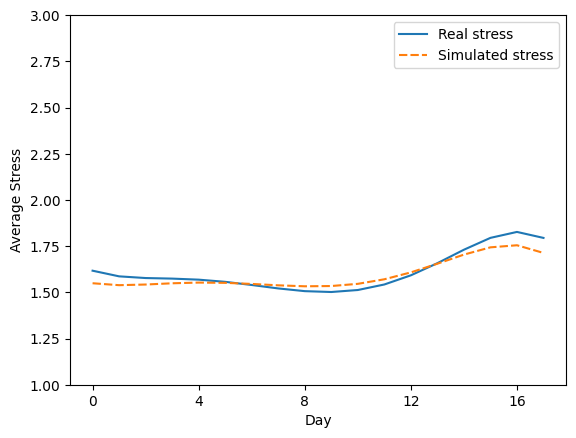

In [174]:
sl_best_group = None
sl_min_distance = 100000
sl_best_users = []
for group_name, group in sl_results['variables']['WorkerAgent'].groupby('sample_id'):
    da = group.groupby('t').mean()[['stress']]
    i = sl_results['parameters']['sample'].loc[group_name]['i']
    sl_test_users = pickle.load(open('../trained_models/sl_data_complete_test_users_{}.pickle'.format(i), "rb"))
    da['real_stress'] = sl_data[sl_data['user'].isin(sl_test_users)].reset_index().groupby('date').mean(numeric_only=True).reset_index()['stress']
    # distance = np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(da['stress'], da['real_stress'])]))
    da['distance'] = (da['stress']-da['real_stress'])*(da['stress']-da['real_stress'])
    distance = np.sqrt(da['distance'].sum())
    
    if sl_min_distance > distance:
        sl_min_distance = distance
        sl_best_group = group
        sl_best_users = sl_test_users

sl_final_results = pd.DataFrame(index=sl_best_group.groupby('t').mean().index)
sl_final_results['simulated_stress'] = sl_best_group.groupby('t').mean()['stress']
sl_final_results['real_stress'] =sl_data[sl_data['user'].isin(sl_best_users)].reset_index().groupby('date').mean(numeric_only=True).reset_index()['stress']

poly = np.polyfit(sl_best_group.groupby('t').mean().index, sl_final_results['real_stress'], deg=5)
poly2 = np.polyfit(sl_best_group.groupby('t').mean().index, sl_final_results['simulated_stress'], deg=5)

sl_final_results['real_stress_poly'] = np.polyval(poly, sl_best_group.groupby('t').mean().index)
sl_final_results['simulated_stress_poly'] = np.polyval(poly2, sl_best_group.groupby('t').mean().index)

g = sns.lineplot(data=sl_final_results[['real_stress_poly', 'simulated_stress_poly']])
g.set(xlabel='Day', ylabel='Average Stress', ylim=(1, 3), xticks=range(0, sl_best_group.groupby('t').mean().index.shape[0], 4))
for t, l in zip(g.legend_.texts, ['Real stress', 'Simulated stress']):
    t.set_text(l)

In [167]:
g.legend_

In [33]:
parameters = {
    'dataset_path': '../data/processed/fbk_data_complete.csv',
    'test_users': '../trained_models/fbk_data_complete_test_users',
    'seed': 24091993,
    'i': ap.IntRange(0, 199),
    'predictor_path': '../trained_models/fbk_data_complete_model_trained',
    'steps': sl_data.reset_index()['date'].unique().shape[0]-1,
    'dataset_name': 'FBK',
    'scaler_path': '../trained_models/fbk_data_complete_scaler_trained',
}

sample = ap.Sample(parameters, 200)
model = ap.Experiment(StressModel, sample, iterations=1, record=True)

sl_results = model.run()

Scheduled runs: 200
Completed: 200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:16.417753


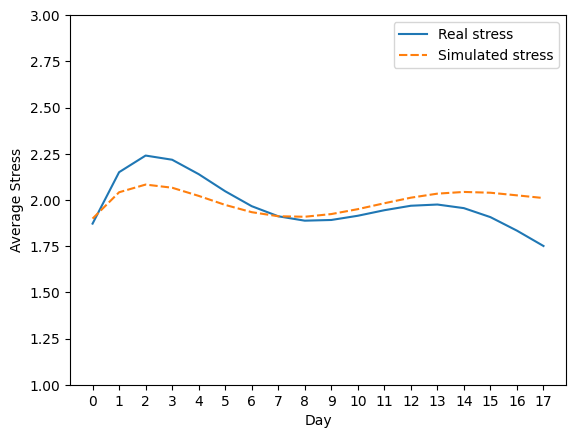

In [34]:
sl_best_group = None
sl_min_distance = 100000
sl_best_users = []
for group_name, group in sl_results['variables']['WorkerAgent'].groupby('sample_id'):
    da = group.groupby('t').mean()[['stress']]
    i = sl_results['parameters']['sample'].loc[group_name]['i']
    sl_test_users = pickle.load(open('../trained_models/fbk_data_complete_test_users_{}.pickle'.format(i), "rb"))
    da['real_stress'] = fbk_data[fbk_data['user'].isin(sl_test_users)].reset_index().groupby('date').mean(numeric_only=True).reset_index()['stress']
    # distance = np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(da['stress'], da['real_stress'])]))
    corr_matrix = np.corrcoef(da['real_stress'], da['stress'])
    corr = corr_matrix[0, 1]
    R_sq = corr**2

    #da['distance'] = (da['stress']-da['real_stress'])*(da['stress']-da['real_stress'])
    #distance = np.sqrt(da['distance'].sum())
    
    if sl_min_distance > R_sq:
        sl_min_distance = R_sq
        sl_best_group = group
        sl_best_users = sl_test_users

sl_final_results = pd.DataFrame(index=sl_best_group.groupby('t').mean().index)
sl_final_results['simulated_stress'] = sl_best_group.groupby('t').mean()['stress']
sl_final_results['real_stress'] =fbk_data[fbk_data['user'].isin(sl_best_users)].reset_index().groupby('date').mean(numeric_only=True).reset_index()['stress']

poly = np.polyfit(sl_best_group.groupby('t').mean().index, sl_final_results['real_stress'], deg=5)
poly2 = np.polyfit(sl_best_group.groupby('t').mean().index, sl_final_results['simulated_stress'], deg=5)

sl_final_results['real_stress_poly'] = np.polyval(poly, sl_best_group.groupby('t').mean().index)
sl_final_results['simulated_stress_poly'] = np.polyval(poly2, sl_best_group.groupby('t').mean().index)

g = sns.lineplot(data=sl_final_results[['real_stress_poly', 'simulated_stress_poly']])
g.set(xlabel='Day', ylabel='Average Stress', ylim=(1, 3), xticks=range(0, sl_best_group.groupby('t').mean().index.shape[0], 1))
for t, l in zip(g.legend_.texts, ['Real stress', 'Simulated stress']):
    t.set_text(l)

Scheduled runs: 10000
Completed: 10000, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:35:58.030791


[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Stress'),
 (1.0, 3.0),

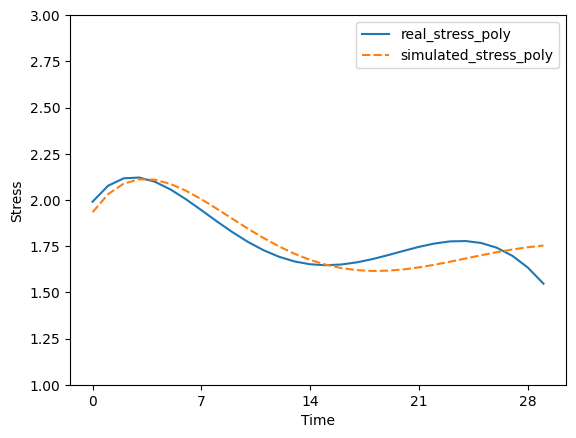

In [6]:
parameters = {
    'dataset_path': '../data/processed/fbk_data_complete.csv',
    'test_users': '../trained_models/fbk_data_complete_test_users.pickle',
    'seed': 2491993,
    'predictor': fbk_model,
    'change_predictor' : fbk_bin_model,
    'steps': fbk_data.reset_index()['date'].unique().shape[0]-1,
    'dataset_name': 'FBK',
    'bin_scaler': fbk_bin_scaler,
    'scaler': fbk_scaler,
    'soft_reduction' : ap.Range(0.1, 0.9),
    'hard_reduction' : ap.Range(0.1, 0.9),
}

sample = ap.Sample(parameters, 10)
model = ap.Experiment(StressModel, sample, iterations=100, record=True)
fbk_results = model.run()

fbk_best_group = None
fbk_min_distance = 100000
for group_name, group in fbk_results['variables']['WorkerAgent'].groupby('sample_id'):
    da = group.groupby('t').mean()[['stress']]
    da['real_stress'] = fbk_data[fbk_data['user'].isin(['u24', 'u12', 'u28', 'u15', 'u6', 'u29', 'u18'])].reset_index().groupby('date').mean(numeric_only=True).reset_index()['stress']
    # distance = np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(da['stress'], da['real_stress'])]))
    da['distance'] = (da['stress']-da['real_stress'])*(da['stress']-da['real_stress'])
    distance = np.sqrt(da['distance'].sum())
    if fbk_min_distance > distance:
        fbk_min_distance = distance
        fbk_best_group = group

fbk_final_results = pd.DataFrame(index=fbk_best_group.groupby('t').mean().index)
fbk_final_results['simulated_stress'] = fbk_best_group.groupby('t').mean()['stress']
fbk_final_results['real_stress'] =fbk_data[fbk_data['user'].isin(['u24', 'u12', 'u28', 'u15', 'u6', 'u29', 'u18'])].reset_index().groupby('date').mean(numeric_only=True).reset_index()['stress']

poly = np.polyfit(fbk_best_group.groupby('t').mean().index, fbk_final_results['real_stress'], deg=5)
poly2 = np.polyfit(fbk_best_group.groupby('t').mean().index, fbk_final_results['simulated_stress'], deg=5)

fbk_final_results['real_stress_poly'] = np.polyval(poly, fbk_best_group.groupby('t').mean().index)
fbk_final_results['simulated_stress_poly'] = np.polyval(poly2, fbk_best_group.groupby('t').mean().index)

g = sns.lineplot(data=fbk_final_results[['real_stress_poly', 'simulated_stress_poly']])
g.set(xlabel='Time', ylabel='Stress', ylim=(1, 3), xticks=range(0, fbk_best_group.groupby('t').mean().index.shape[0]+2, 7))

In [ ]:
fbk_min_distance

0.9584064154328568